### packages

In [1]:
# all these packages ship with Julia directly and do not require installation
using LinearAlgebra, Plots, Statistics

### plot settings as chosen in paper. feel free to ignore.

In [2]:
include("./plot_settings.jl")

## functions

### functions for generic framework

In [3]:
function Δp(p::Vector{Float64},R::Vector{Float64}) # <--- RHS of Master equation
    flow=zeros(length(p))
    for k in 2:length(p)
        flow_to_right=p[k-1]*R[k-1]
        flow[k-1]-= flow_to_right   # <---- the probability 'flow_to_right' flows from k-1
        flow[k]  += flow_to_right   # <---- to k
    end
    return flow
end

function trial!(p::Vector{Float64},R::Vector{Float64}) # <--- update p(k|M) by adding RHS
    p.+=Δp(p,R)
end

function p_M_T(M,x)  #<--- Poisson probability. Doing a few case distinctions here for numerical reasons (factorials become really big really fast)
    x>30 ? (return 1/(sqrt(2*pi*x))*exp(- (M-x)^2/(2*x) )) : nothing   # <--- Gaussian for large x

    if M<13
        return exp(-x) * x^M / factorial(M)   # <---- Poisson
    elseif M<69
        stirling_factor= 1 + 1/(12*M) + 1/(288*M^2) - 139/(51840*M^3) 
        return exp(M-x)*(x/M)^M/(sqrt(2*pi*M)*stirling_factor)  # <--- Poisson with Stirling
    else
        return 0.0        # <--- this is where, for x=29, the correct value is <1e-13
    end
end

function pdf_k(x,δmax)  #<--- p(k) with 'M' already integrated out.

    ΔM=1   # <------------------------ increments / spacing
    Δk=1

    M_min=0   # <--------------------- minimum values for variables
    k_min=0

    M_max=max(100, Integer( 10*ceil(x) ) ) # <---- maximum values for variables
    k_max=100

    vM=M_min:ΔM:M_max  # <------------ arrays with all possible values
    vk=k_min:Δk:k_max

    #trajectory lengths
    d=deltas(δmax,length(vk))
    dmax=d[1]*δmax

    #generate insertion probabilities
    R=zeros(length(vk)-1)
    for k in 1:length(vk)-1
        R[k]=p_insert(d[k],dmax)
    end

    #prob. density for M
    pdf_M=Float64.([ p_M_T(M,x)  for M in vM])    # <---- Poisson prob. for M other reqs to spawn during a req of given duration 'T'

    #prob. density for k
    pdf_k=zeros(length(vk))
    p_k_M=zeros(length(vk))
    p_k_M[1]=1.0           # <---- after 0 trials (M=0), k=0

    pdf_k+=p_k_M*pdf_M[1]*ΔM
    for M in vM[2:end]   # <---- this loop goes through this sum: p(k)=∑p(k|M)p(M)
        pdf_k+=p_k_M*pdf_M[M+1]*ΔM
        trial!(p_k_M,R)
    end

    return pdf_k
end

function η(x,δmax,χ)  #<--- efficiency value

    pk=pdf_k(x,δmax)
    vk=0:length(pk)-1

    b=[1+χ*k for k in vk]
    d=deltas(δmax,length(vk))
    
    return dot(pk,b./d)
end

error(x,N,δmax,percentage,χ)=-1+x/(N*η(x,δmax,χ)/percentage)  #<--- supply-demand balance is fulfilled when this is zero

function find_x(N,percentage,δmax,χ) #<--- secante method for finding root of 'error' function
    x1,v1=(N^1.20,error(N^1.20,N,δmax,percentage,χ)) #<--- initial guess
    x2,v2=(N^1.15,error(N^1.15,N,δmax,percentage,χ))
    x3,v3=(0.0,0.0)

    while true   # trying to solve f = N*η(f) / 0.8 via secante method
        x3=x2-v2*(x2-x1)/(v2-v1)
        v3=error(x3,N,δmax,percentage,χ)
        abs(v3)<1e-3 ? (return x3) : nothing
        x1=x2
        v1=v2
        x2=x3
        v2=v3
    end
end

find_x (generic function with 1 method)

### functions specific to ride pooling on a Euclidian square

In [4]:
# iterative rule for d_k
deltas(deltamax,kmax)=[deltamax-(deltamax-1)*((deltamax-δbar(deltamax))/(deltamax-1))^k for k in 0:kmax-1]

#pickup probability = area of ellipse around flattened route
p_pickup(d,dmax)=(pi*dmax*sqrt(dmax^2-d^2)/8) / (1/0.5214054331)^2

#R = p_insert = product of pickup and dropoff probs.
p_insert(d,dmax)=p_pickup(d,dmax)*p_pickup(d,dmax)

#average delta value inside an ellipse of x=δmax
δbar(x)= 1+(2*x/3 + 1/(3*x) - 1)

χ=0.5;

## plots

In [5]:
deltamax=2.0

2.0

### p(k|M)

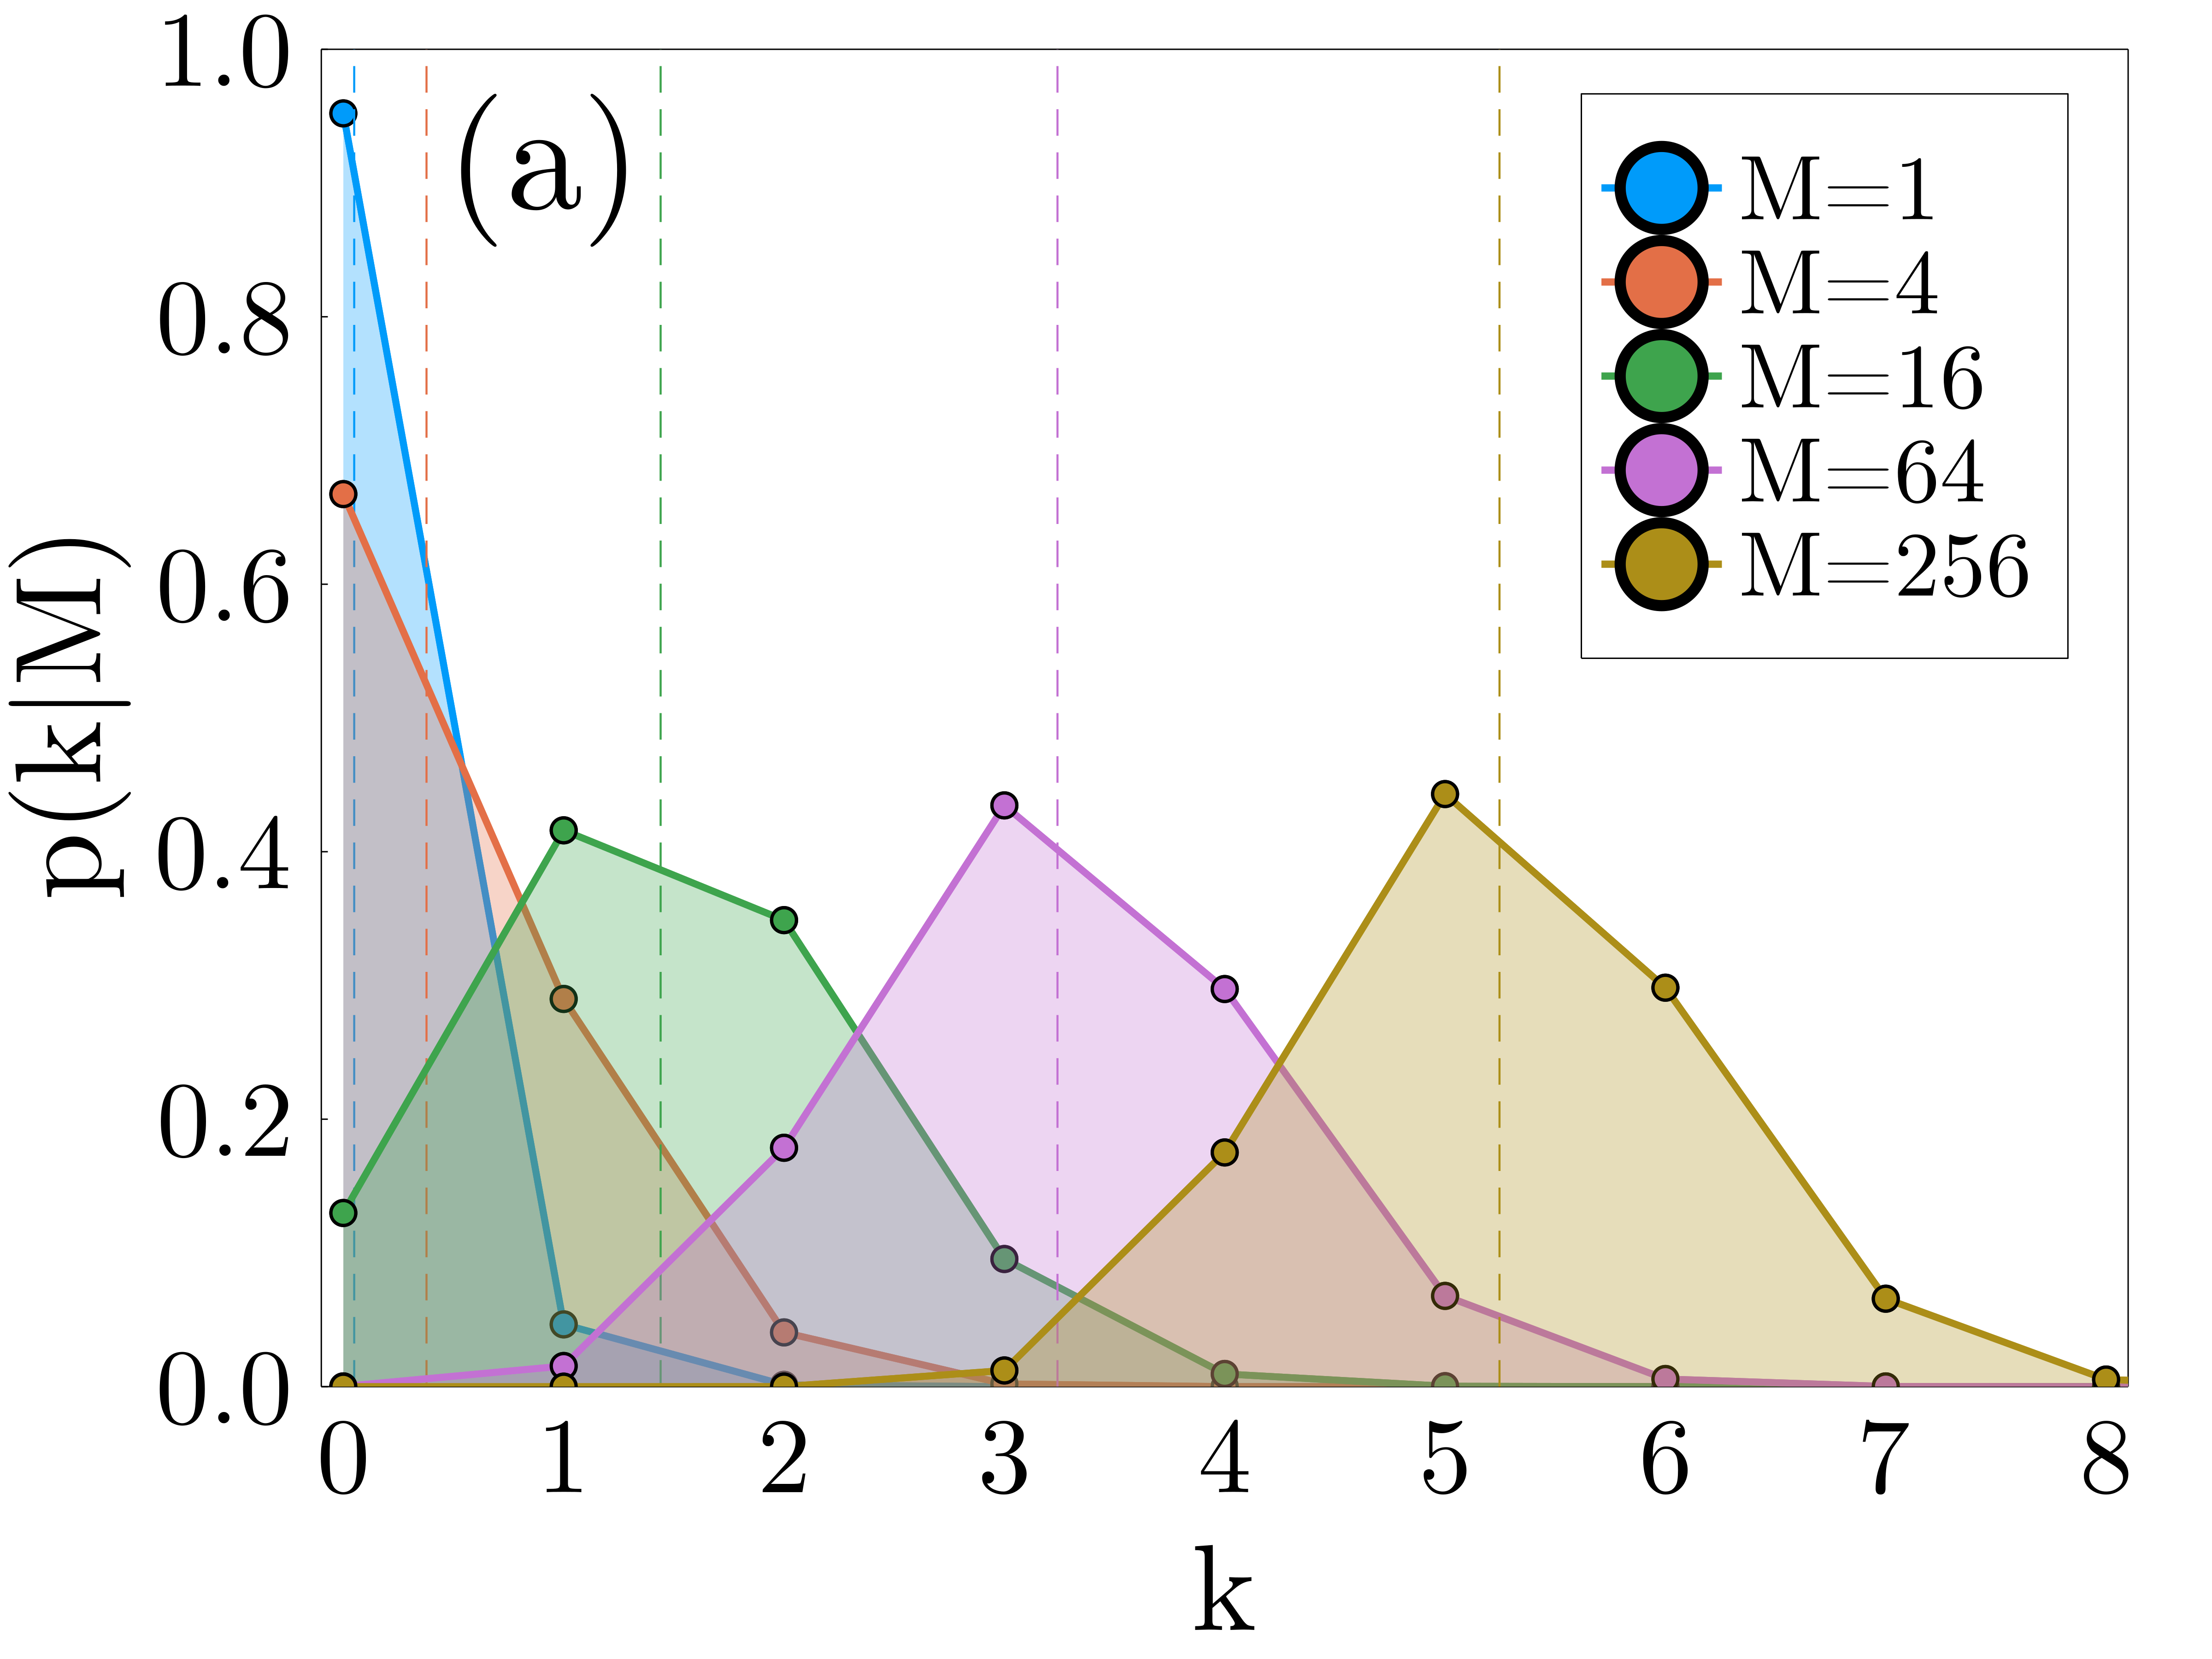

In [6]:
xticks=[1,10,100,1000,10000]
yticks=[1,10,100,1000,10000,10^5]
xmin,xmax=-0.1,8.1
ymin,ymax=0,1

p=plot(
    xlim=(xmin,xmax),
    ylim=(ymin,ymax),
    xticks=0:10,
    yticks=0:0.2:1.0,
    xlabel="k",
    ylabel="p(k|M)")

for (i,x) in enumerate([1,4,16,64,256])
    pkm=pdf_k(x,deltamax)
    plot!(0:100,pkm,label="M=$(x)", color=i)
    plot!(0:100,pkm,label="",fill = (0, 0.3), color=i)
    vline!([dot(0:100,pkm)],label="",color=i,line=(1.5,:dash))
end
annotate!((0.12300767274809593,0.92),text("(a)", myfont, :black, pointlg))

In [7]:
#savefig("../figures/model_pkm.pdf")

### $\eta(x)$

In [8]:
#find eta(x)

Δk=1   # <------------------------ increments / spacing
k_min=0
k_max=100
vk=k_min:Δk:k_max
xs=exp.(range(log(1),log(100000),length=30))
etas=[η(x,deltamax,χ) for x in xs];

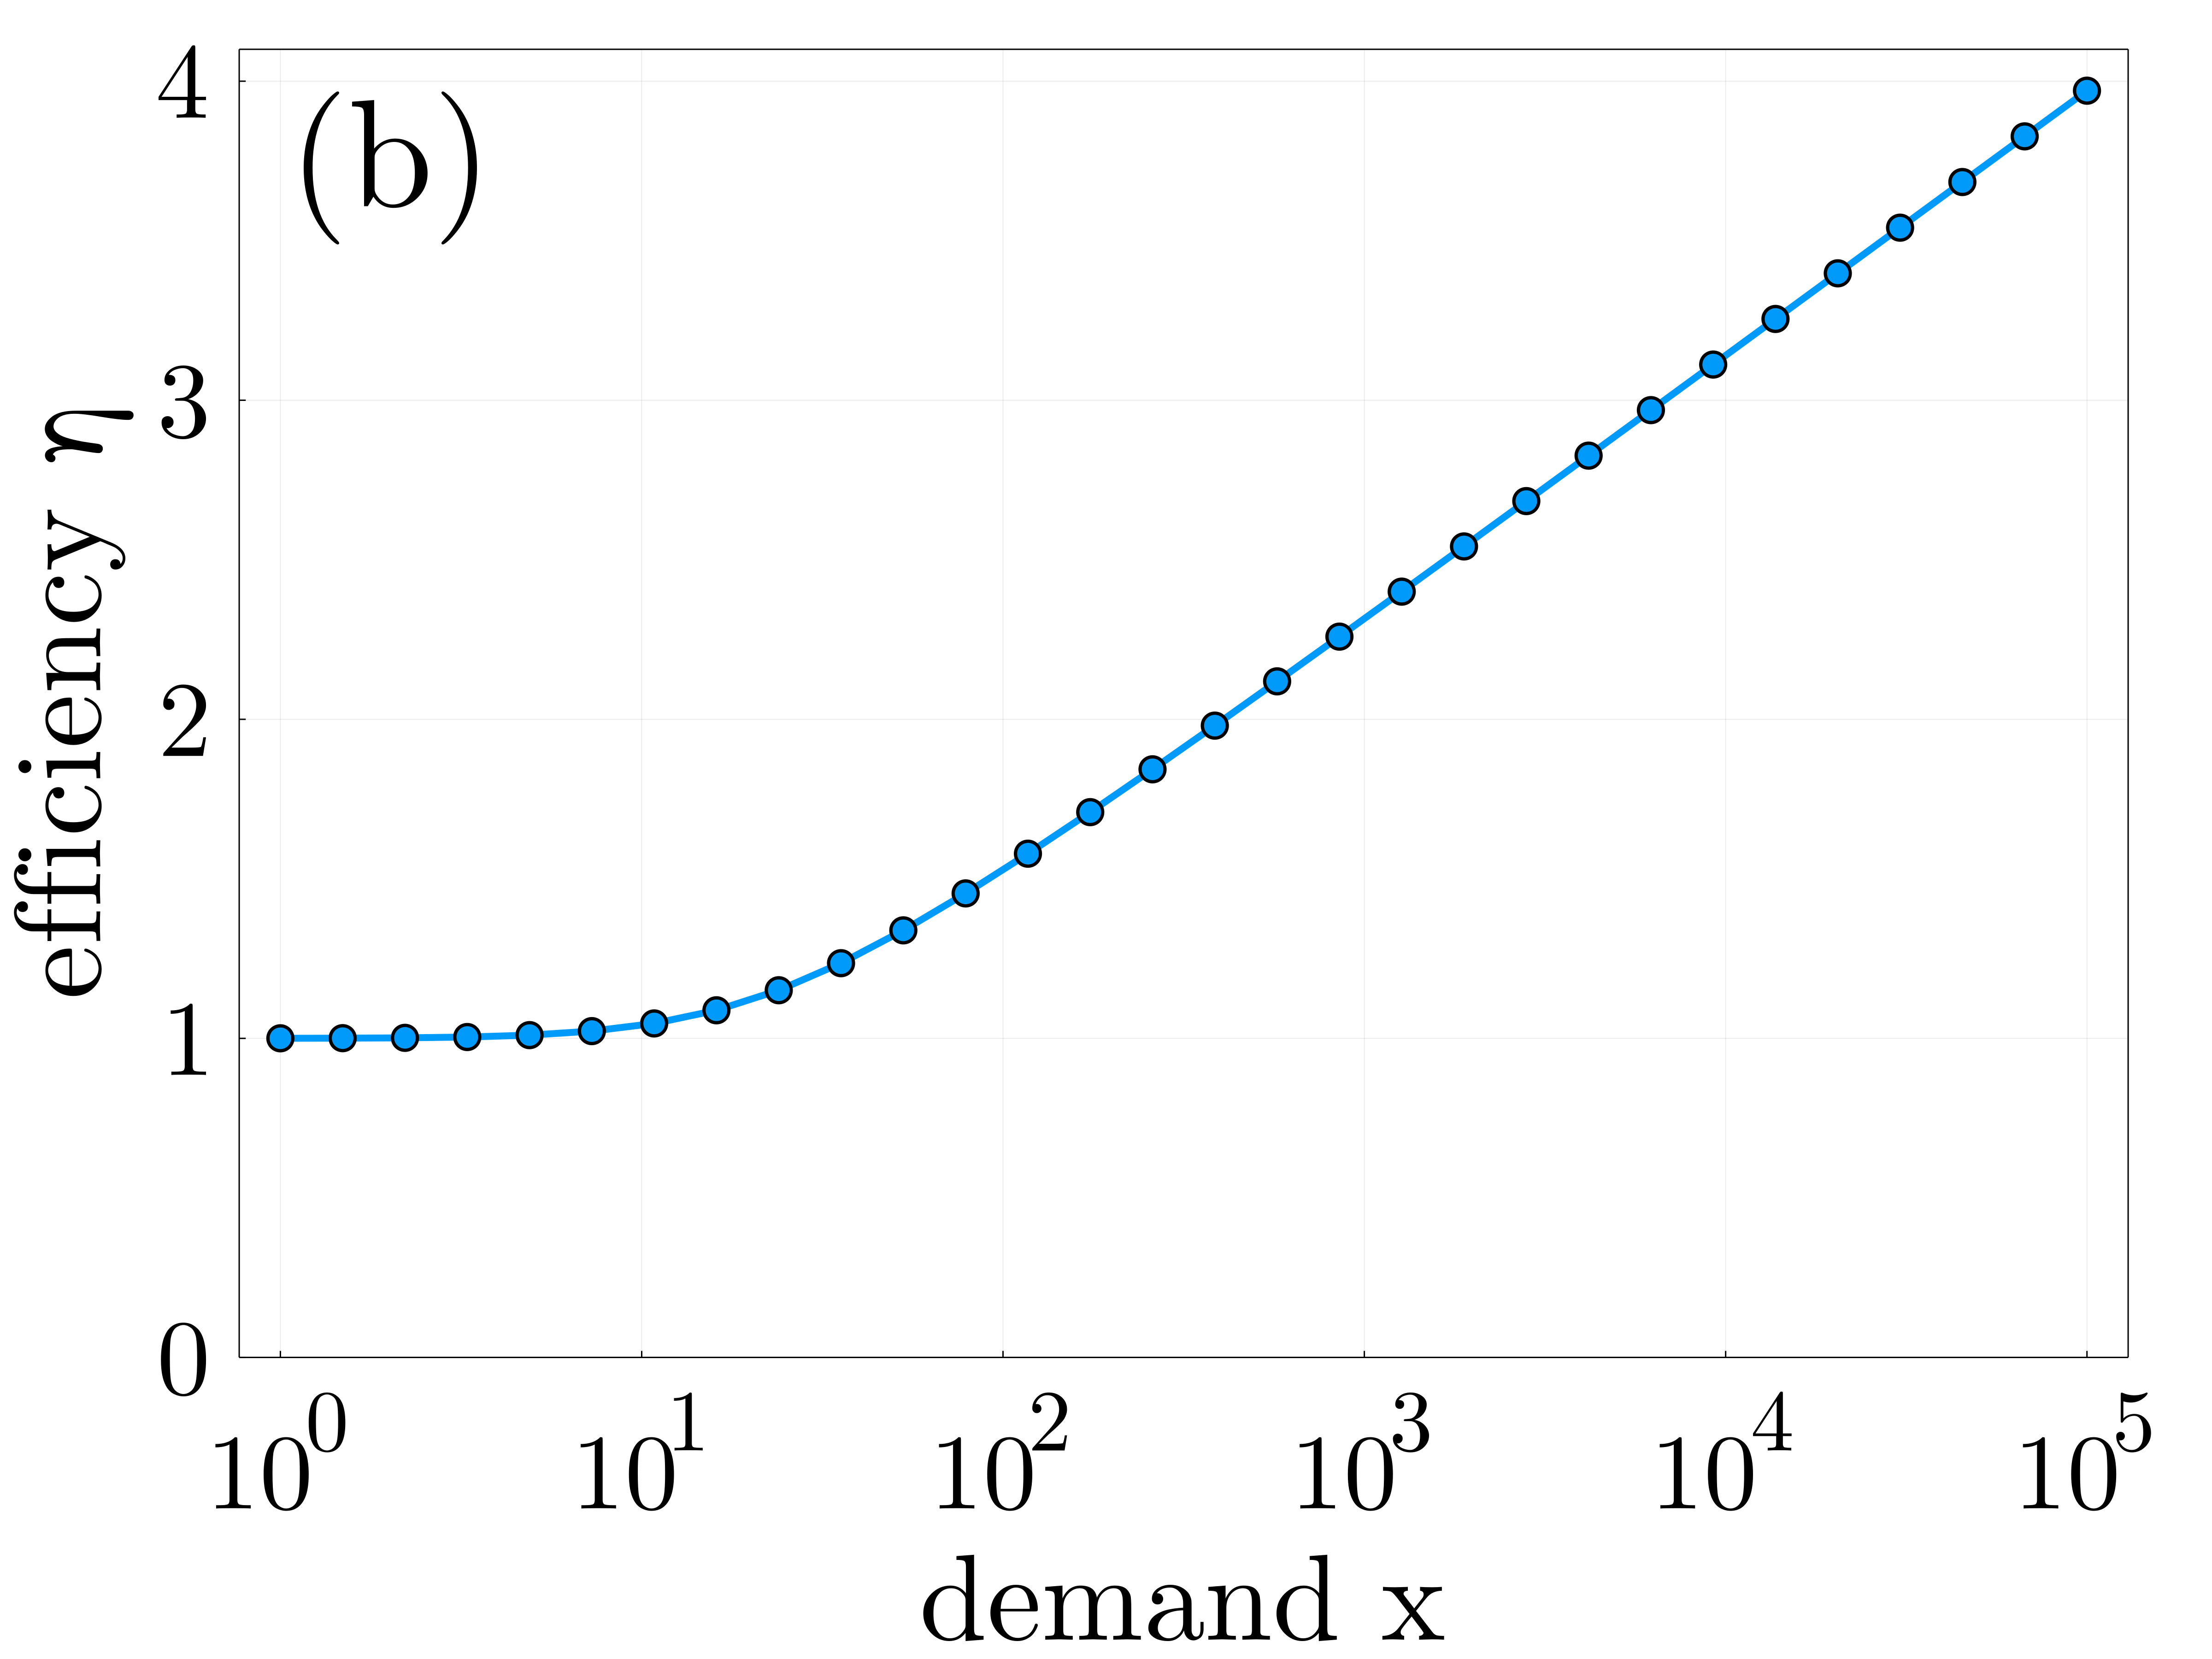

In [9]:
#plot eta(x)

xticks=[1,10,100,1000,10000,100000]
xmin,xmax=1.0/1.3,1.3*10^5
ymin,ymax=0,4.1

plot(xs,etas,xticks=xticks,xaxis=:log,
xlab="demand x",ylab="efficiency $(Char(951))",
legend=:none,grid=true,
xlim=(xmin,xmax),
ylim=(ymin,ymax))

xperc,yperc=0.08,0.92
xperc=(exp(log(xmin)+xperc*(log(xmax)-log(xmin))) -xmin)/(xmax-xmin)
annotate!((xperc,yperc),text("(b)", myfont, :black, pointlg))

In [10]:
#savefig("../figures/model_eta.pdf")

### x(N)

In [11]:
#find x(N)

Ns=exp.(range(log(1.01),log(10000),length=30))  #<--- choose fleet sizes N

served_percentage=0.8

Xs=zeros(length(Ns))
for (index,value) in enumerate(Ns)  #<--- find corresponding x values for each N
    Xs[index]=find_x(value,served_percentage,deltamax,χ)
end

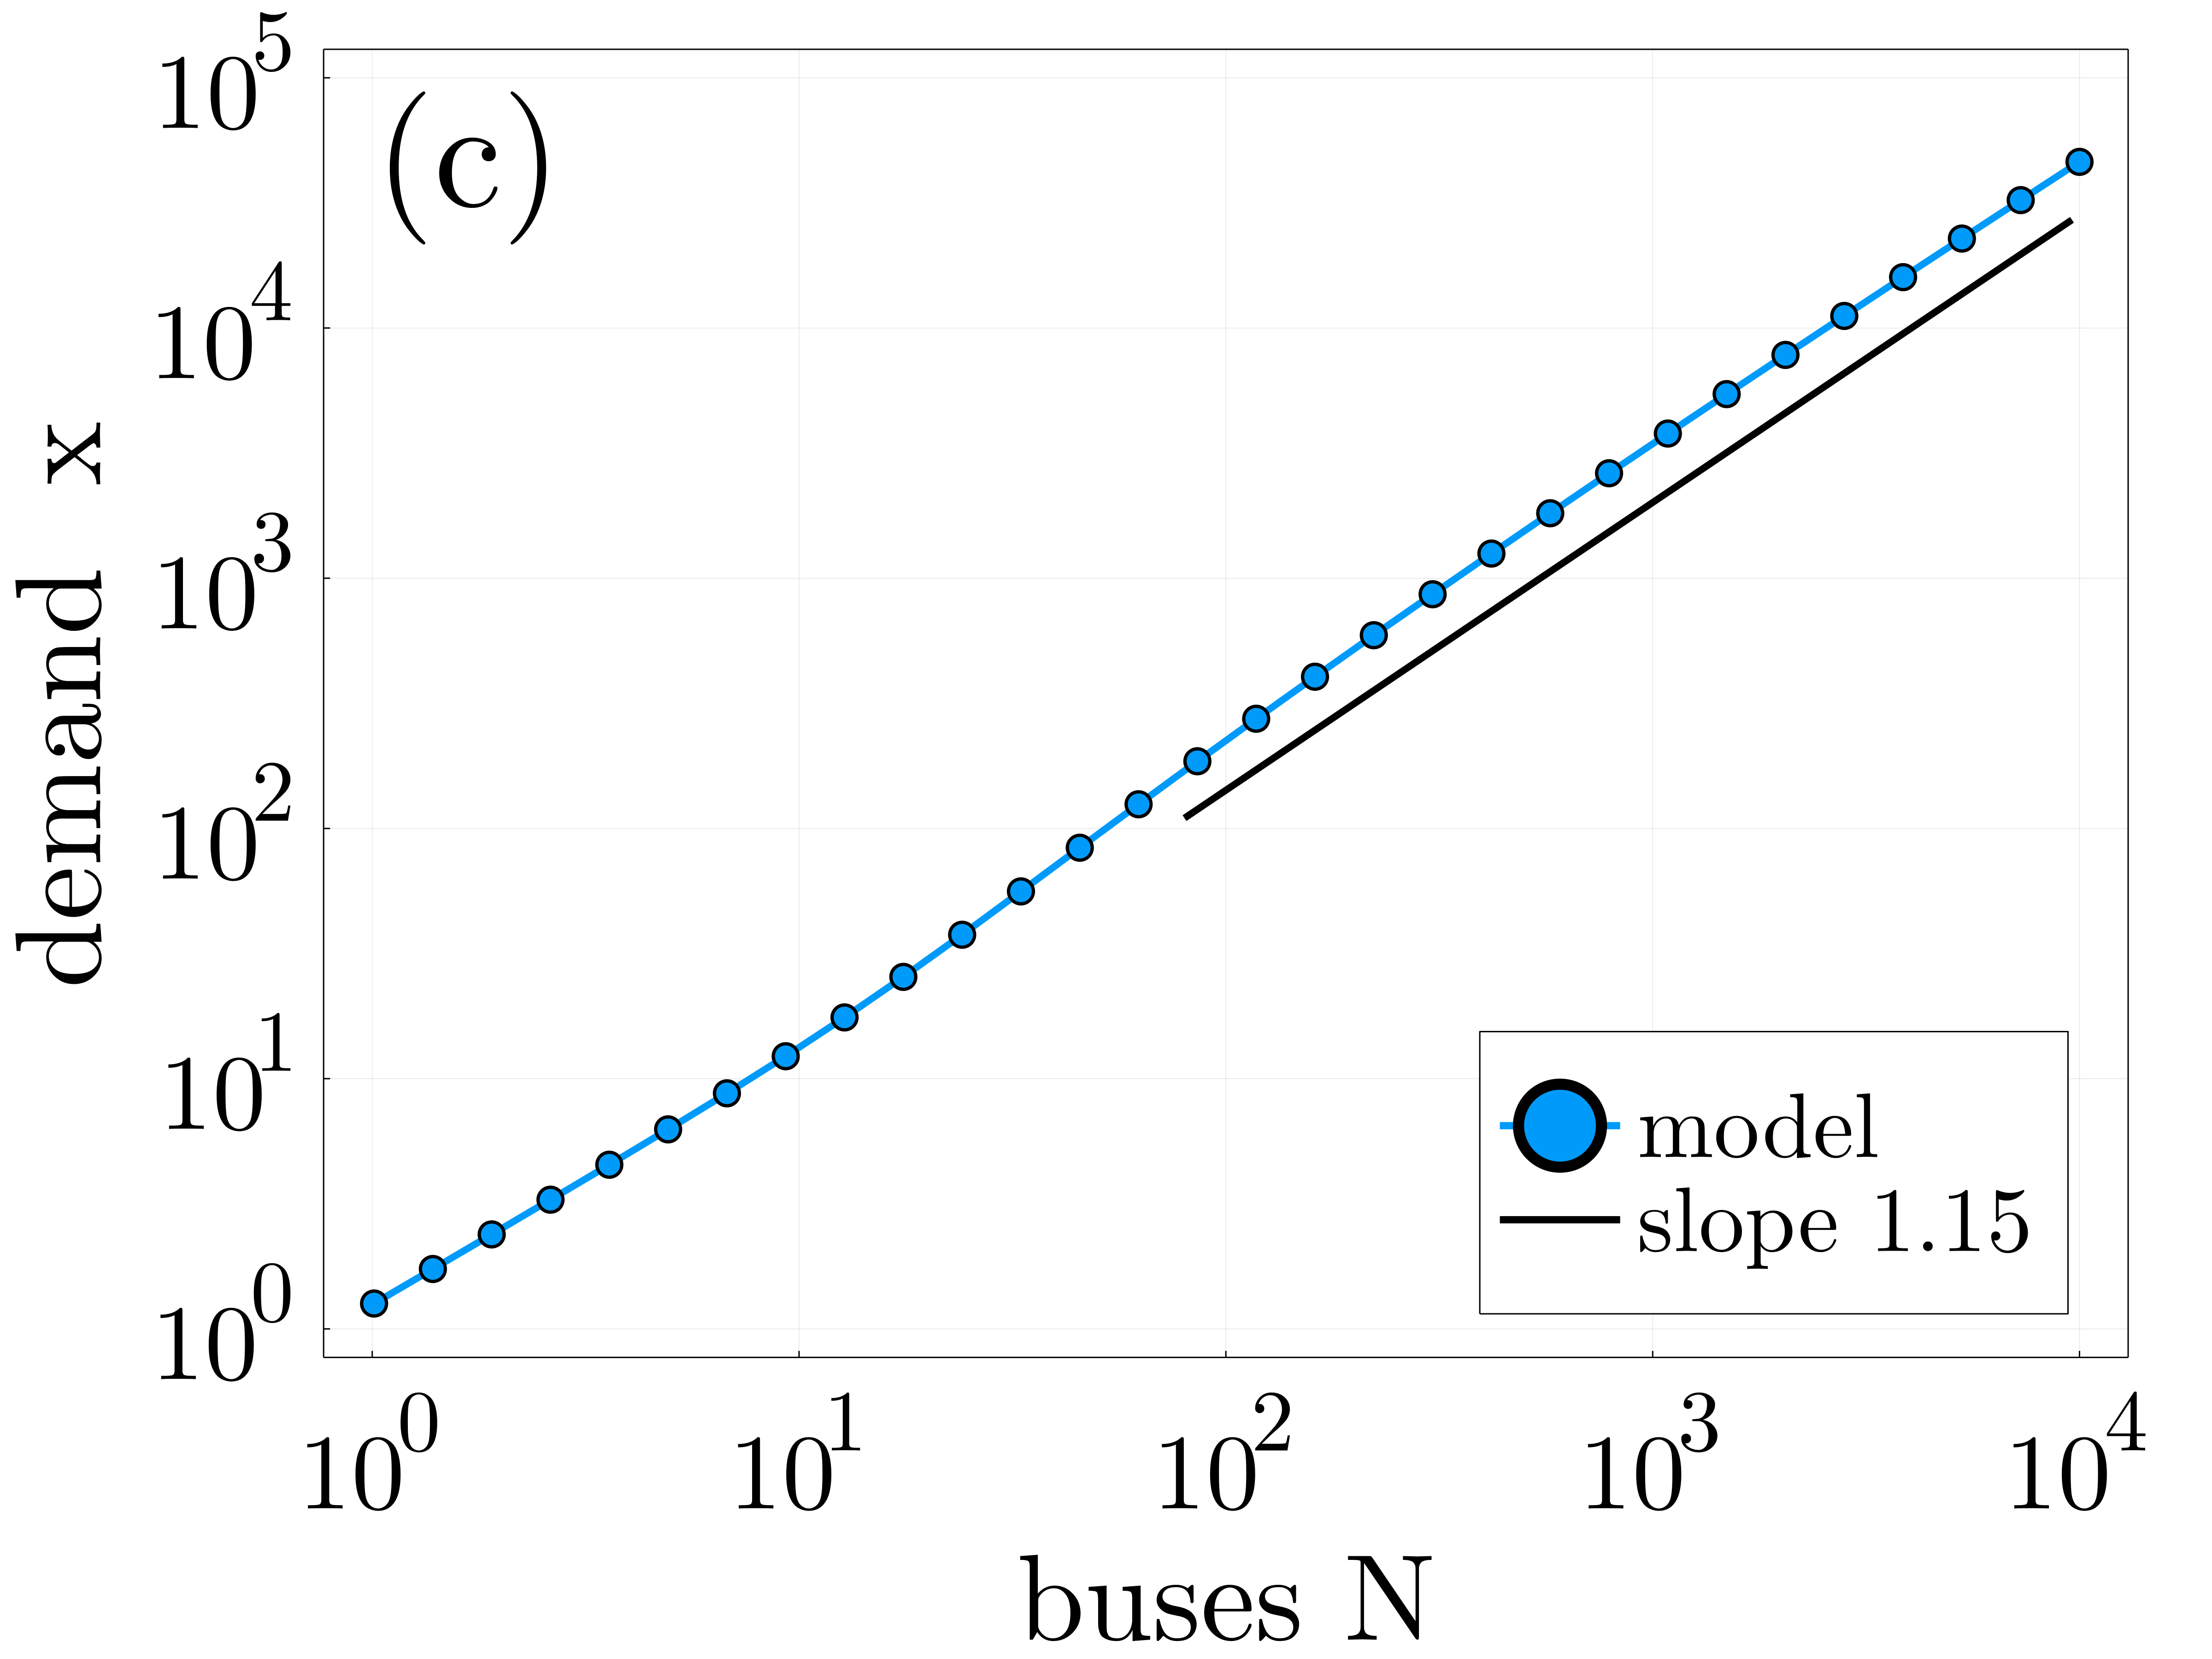

In [12]:
#plot x(N)

xticks=[1,10,100,1000,10000]
yticks=[1,10,100,1000,10000,10^5]
xmin,xmax=1/1.3,1.3*10^4
ymin,ymax=1/1.3,1.3*10^5

plot(Ns,Xs,
    xticks=xticks,
    yticks=yticks,
    xlim=(xmin,xmax),
    ylim=(ymin,ymax),
    xaxis=:log,
    yaxis=:log,
    xlab="buses N",ylab="demand  x",
    label="model",grid=true,
    legend=:bottomright)

plot!([80,120*80],[110,120^1.15*110],label="slope 1.15",markersize=0,linewidth=2.5*upscale,color=:black)

xperc,yperc=0.08,0.92
xperc=(exp(log(xmin)+xperc*(log(xmax)-log(xmin))) -xmin)/(xmax-xmin)
yperc=(exp(log(ymin)+yperc*(log(ymax)-log(ymin))) -ymin)/(ymax-ymin)
annotate!((xperc,yperc),text("(c)", myfont, :black, pointlg))

In [13]:
#savefig("../figures/model_fleetsize.pdf")